In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [2]:

img1 = np.asarray(Image.open("000000.png"))
img2 = np.asarray(Image.open("000005.png"))
K = np.array([[707.0912, 0., 601.8873],
           [0., 707.0912, 183.1104],
           [0., 0.,       1.       ]])    # kitti sequence 1

In [3]:
def get_keypoints(img1, img2):
    orb = cv2.ORB_create(3000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
    search_params = dict(checks=50)
    matcher = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)

    matches = matcher.knnMatch(des1, des2, k=2)
    good = []

    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append([m])

    x1 = np.float32([ kp1[m[0].queryIdx].pt for m in good ])
    x2 = np.float32([ kp2[m[0].trainIdx].pt for m in good ])
    return x1, x2


# def get_keypoints(img1, img2):
#     orb = cv2.ORB_create(nfeatures=2000)
#
#     keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
#     keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
#     bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)
#
#     # Find matching points
#     matches = bf.knnMatch(descriptors1, descriptors2, k=2)
#     good = []
#     for m, n in matches:
#         if m.distance < 0.5 * n.distance:
#             good.append(m)
#     p_source = np.float32([keypoints1[good_match.queryIdx].pt for good_match in good]).reshape(-1, 2)
#     p_target = np.float32([keypoints2[good_match.trainIdx].pt for good_match in good]).reshape(-1, 2)
#     N = p_source.shape[0]
#     p_source = np.concatenate([p_source, np.ones((N, 1))], axis=-1)
#     p_target = np.concatenate([p_target, np.ones((N, 1))], axis=-1)
#     return p_source, p_target


def draw_matches(img1, points_source, img2, points_target):
    r, c = img1.shape[:2]
    r1, c1 = img2.shape[:2]

    output_img = np.zeros((max([r, r1]), c + c1, 3), dtype='uint8')
    output_img[:r, :c, :] = np.dstack([img1])
    output_img[:r1, c:c + c1, :] = np.dstack([img2])

    for p1, p2 in zip(points_source, points_target):
        (x1, y1) = p1[:2]
        (x2, y2) = p2[:2]

        cv2.circle(output_img, (int(x1), int(y1)), 10, (0, 255, 255), 4)
        cv2.circle(output_img, (int(x2) + c, int(y2)), 10, (0, 255, 255), 4)

        cv2.line(output_img, (int(x1), int(y1)), (int(x2) + c, int(y2)), (0, 255, 255), 2)

    return output_img


In [4]:
x1, x2 = get_keypoints(img1, img2)

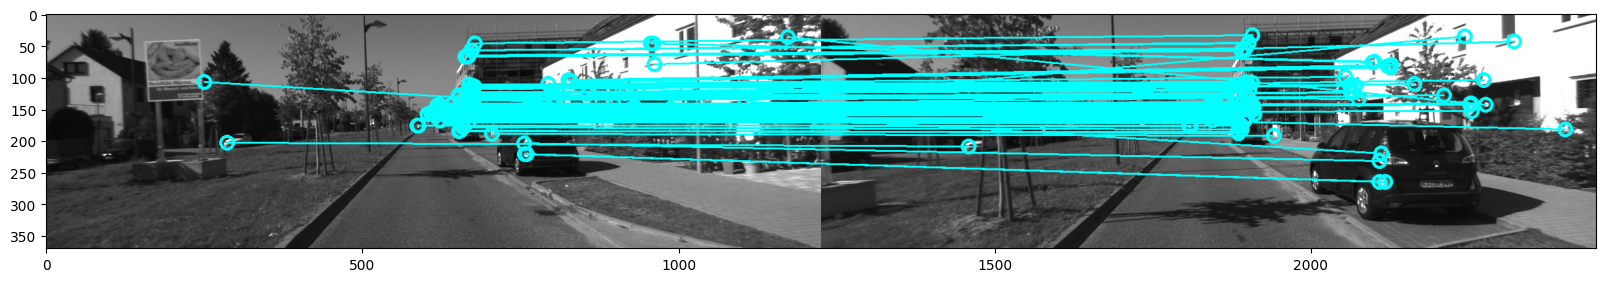

In [5]:
f = plt.figure(figsize=(20, 10))
vis = draw_matches(img1, x1, img2, x2)
plt.imshow(vis)
x1 = x1[:, :2]
x2 = x2[:, :2]

In [17]:
def get_essential_matrix(F, K):
    E = K.T @ F @ K  #np.dot(K.T, np.dot(F, K))
    U, S, V = np.linalg.svd(E)
    S = np.eye(3)
    S[-1] = 0
    E = np.dot(U, np.dot(S, V))
    return E


def LinearTriangulation(K, T1, R1, T2, R2, x1s, x2s):
    P1 = K @ np.concatenate([R1, T1], axis=-1)
    P2 = K @ np.concatenate([R2, T2], axis=-1)
    vs = []
    for x1, x2 in zip(x1s, x2s):
        A = [x1[1] * P1[2, :] - P1[1, :],
             P1[0, :] - x1[0] * P1[2, :],
             x2[1] * P2[2, :] - P2[1, :],
             P2[0, :] - x2[0] * P2[2, :]
             ]
        A = np.array(A).reshape((4, 4))
        B = A.T @ A

        u, s, vh = np.linalg.svd(B, full_matrices=False)
        vs.append(vh[3, 0:3] / -vh[3, 3])
    return np.array(vs)


def displaycorrespondence(img, x, xp):
    plt.figure()
    plt.imshow(img)
    err = 0
    for i in range(len(x)):
        plt.plot([xp[i, 0], x[i, 0]], [xp[i, 1], x[i, 1]])
        plt.scatter(x[i, 0], x[i, 1], c='r')
        plt.scatter(xp[i, 0], xp[i, 1], c='b')
        err = err + (x[i, :] - xp[i, :]) ** 2
    err = (sum(err) / len(err)) ** 0.5
    plt.text(10, 10, 'err = ' + str(err))
    return err


def EssToCameraPose(E):
    u, d, v = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

    t = u[:, -1]

    R1 = u @ W @ v
    R2 = u @ W.T @ v
    if np.linalg.det(R1) < 0:
        R1 = R1 * -1
    if np.linalg.det(R2) < 0:
        R2 = R2 * -1
    return R1, R2, np.array([t]).T

In [26]:
# F,_ = cv2.findFundamentalMat(x1, x2)
# E = get_essential_matrix(F, K)
# F,E

(array([[ 8.01213557e-07, -3.12896977e-04,  5.31827221e-02],
        [ 3.18651618e-04, -2.54834638e-06, -1.95946452e-01],
        [-5.50561440e-02,  1.91964198e-01,  1.00000000e+00]]),
 array([[-2.81329110e-03, -9.99758807e-01, -1.62923473e-02],
        [ 9.99647001e-01, -2.72299114e-03, -2.04143018e-02],
        [ 1.68232511e-02,  1.44102423e-02, -1.07147186e-04]]))

In [29]:
F,_ = cv2.findFundamentalMat(x1, x2)
E,_ = cv2.findEssentialMat(x1, x2, K, threshold=1)
F,E

(array([[ 8.01213557e-07, -3.12896977e-04,  5.31827221e-02],
        [ 3.18651618e-04, -2.54834638e-06, -1.95946452e-01],
        [-5.50561440e-02,  1.91964198e-01,  1.00000000e+00]]),
 array([[-1.28720172e-03, -7.06912566e-01, -1.28431298e-02],
        [ 7.06962209e-01, -1.21681737e-03,  6.41481400e-03],
        [ 1.27021276e-02, -1.04152007e-02, -7.33967898e-05]]))

In [30]:
R, Rs, C = EssToCameraPose(E)
R, Rs, C

(array([[-0.99971508,  0.00225208, -0.023763  ],
        [-0.00139209, -0.99934559, -0.03614495],
        [-0.02382885, -0.03610157,  0.99906399]]),
 array([[ 9.99982687e-01, -1.71860145e-03, -5.62779268e-03],
        [ 1.71960875e-03,  9.99998506e-01,  1.74152300e-04],
        [ 5.62748498e-03, -1.83826887e-04,  9.99984149e-01]]),
 array([[-0.01469842],
        [-0.01798911],
        [ 0.99973014]]))

In [23]:
R, Rs, C = cv2.decomposeEssentialMat(E)
R, Rs, C

(array([[ 9.99982687e-01, -1.71860145e-03, -5.62779268e-03],
        [ 1.71960875e-03,  9.99998506e-01,  1.74152300e-04],
        [ 5.62748498e-03, -1.83826887e-04,  9.99984149e-01]]),
 array([[-0.99971508,  0.00225208, -0.023763  ],
        [-0.00139209, -0.99934559, -0.03614495],
        [-0.02382885, -0.03610157,  0.99906399]]),
 array([[ 0.01469842],
        [ 0.01798911],
        [-0.99973014]]))

<Figure size 6000x4500 with 0 Axes>

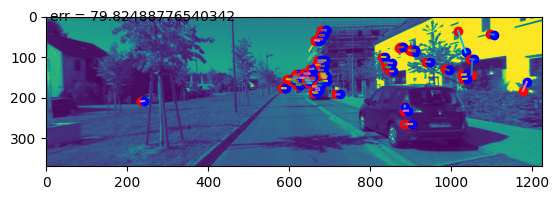

<Figure size 6000x4500 with 0 Axes>

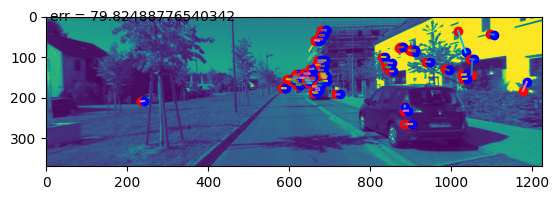

<Figure size 6000x4500 with 0 Axes>

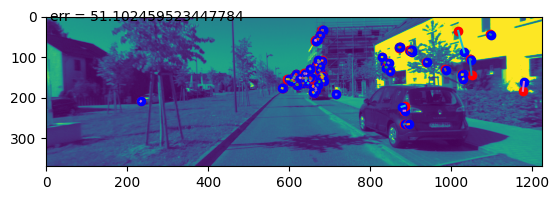

<Figure size 6000x4500 with 0 Axes>

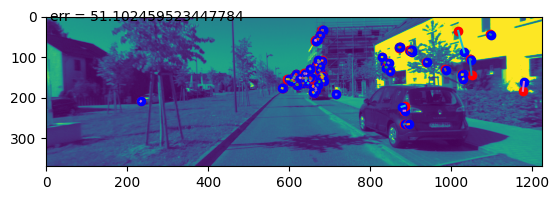

In [31]:

errs = []
Xs = []
R, Rs, C = EssToCameraPose(E)
CandR = list(zip([C, -C, C, -C], [R, R, Rs, Rs]))
for c, r in CandR:
    X = LinearTriangulation(K, np.zeros((3, 1)), np.eye(3), c, r, x1, x2)
    X2 = r @ (X.T - c)
    x1p = K @ X.T
    x1p = x1p / x1p[-1, :]
    x2p = K @ r @ (X.T - c)
    x2p = x2p / x2p[-1, :]
    f = plt.figure(figsize=(60, 45))
    err = displaycorrespondence(img2, x2, x2p[:-1, ].T)
    errs.append(err)
    Xs.append(X)
    # break

lowind = errs.index(min(errs))
C, R = CandR[lowind]
X = Xs[lowind]

In [23]:
def Camerapos(X, x, K):
    # X is 3 x N
    # x is 2 x N
    # K is 3 x 3
    N = X.shape[0]
    x = np.concatenate([x, np.ones((N, 1))], axis=-1)
    x = np.linalg.inv(K) @ x.T
    x = x.T
    X = np.concatenate([X, np.ones((N, 1))], axis=-1)
    A = np.zeros((3 * N, 12))
    for i in range(N):
        A[3 * i] = [0, 0, 0, 0,
                    -X[i, 0], -X[i, 1], -X[i, 2], -X[i, 3],
                    x[i, 1] * X[i, 0], x[i, 1] * X[i, 1], x[i, 1] * X[i, 2], x[i, 1] * X[i, 3]]
        A[3 * i + 1] = [X[i, 0], X[i, 1], X[i, 2], X[i, 3],
                        0, 0, 0, 0,
                        -x[i, 0] * X[i, 0], -x[i, 0] * X[i, 1], -x[i, 0] * X[i, 2], -x[i, 0] * X[i, 3]]
        A[3 * i + 2] = [-x[i, 1] * X[i, 0], -x[i, 1] * X[i, 1], -x[i, 1] * X[i, 2], -x[i, 1] * X[i, 3],
                        x[i, 0] * X[i, 0], x[i, 0] * X[i, 1], x[i, 0] * X[i, 2], x[i, 0] * X[i, 3],
                        0, 0, 0, 0]
    U, S, V = np.linalg.svd(A)
    P = V[-1, :].reshape(3, 4)
    R_t = P / P[-1, -1]
    U, S, V = np.linalg.svd(R_t[:, :3])
    R = U @ V
    t = R_t[:, 3] / S[0]
    if np.linalg.det(R) < 0:
        R = -R
    return R, t